In [1]:
from neuron import h
from stellatecell import StellateCell
from interneuron import Interneuron
import matplotlib.pyplot as plt
import numpy as np
from scipy import fft , signal, fftpack, integrate
h.load_file('stdrun.hoc')

1.0

<h3> Potential Stochastic Resonance Observed in MEC network motif: </h3>

In [2]:
#final
#####create cells, setup synapses#####
h.celsius=37

#create cells
stell_cell1 = StellateCell(0,0,0,0,0)
stell_cell1.soma.insert('stellate_mech')

stell_cell2 = StellateCell(1,5,0,0,0)
stell_cell2.soma.insert('stellate_mech')

intrnrn1 = Interneuron(2,0,-12,0,0)
intrnrn1.soma.insert('naf')
intrnrn1.soma.insert('kdr')
intrnrn1.soma.insert('pas')
intrnrn1.soma.insert('i_theta')


for seg in intrnrn1.soma:
    seg.pas.g=1e-4
    seg.pas.e = -65
    
intrnrn2 = Interneuron(3,5,-12,0,0)
intrnrn2.soma.insert('naf')
intrnrn2.soma.insert('kdr')
intrnrn2.soma.insert('pas')
intrnrn2.soma.insert('i_theta')

for seg in intrnrn2.soma:
    seg.pas.g=1e-4
    seg.pas.e = -65

cells = [[intrnrn1, intrnrn2], [stell_cell1, stell_cell2]]

    
#####setup syanpses#####

#inihibitory synapses
inhb_syn1 = h.fvpre(stell_cell1.soma(0)) 
h.setpointer(intrnrn1.soma(1)._ref_v, 'vpre', inhb_syn1)

inhb_syn2 = h.fvpre(stell_cell2.soma(0))
h.setpointer(intrnrn2.soma(1)._ref_v, 'vpre', inhb_syn2) 

inhb_syn3 = h.fvpre(intrnrn1.soma(0))
h.setpointer(intrnrn2.soma(1)._ref_v, 'vpre', inhb_syn3) 

inhb_syn4 = h.fvpre(intrnrn2.soma(0))
h.setpointer(intrnrn1.soma(1)._ref_v, 'vpre', inhb_syn4) 

inhb_syn=[[inhb_syn1,inhb_syn2],[inhb_syn3,inhb_syn4]]

#inhibitory synaptic conductances
for stell,mutual in zip(inhb_syn[0],inhb_syn[1]):
    stell.gmax =2e-4
    mutual.gmax=4e-4
#inhibitory synaptic rate constants
h.alpha_fvpre=3.33
h.beta_fvpre=0.05


#excitatory synapses
exc_syn1 = h.stell_syn(intrnrn2.soma(0))
h.setpointer(stell_cell1.soma(1)._ref_v, 'vpre', exc_syn1) 
exc_syn2 = h.stell_syn(intrnrn1.soma(0))
h.setpointer(stell_cell2.soma(1)._ref_v, 'vpre', exc_syn2) 

#excitatory synaptic parameters
exc_syn1.gsynbar=exc_syn2.gsynbar=0.12e-4
exc_syn1.asyn=exc_syn2.asyn=10
exc_syn1.bsyn=exc_syn2.bsyn=3.3e-2

#netcons to measure spike times

stell_netc1 = h.NetCon(stell_cell1.soma(0.5)._ref_v,None,sec=stell_cell1.soma)
stell_netc2 = h.NetCon(stell_cell2.soma(0.5)._ref_v,None,sec=stell_cell2.soma)
int_netc1 = h.NetCon(intrnrn1.soma(0.5)._ref_v,None,sec=intrnrn1.soma)
int_netc1.threshold=0
int_netc2 = h.NetCon(intrnrn2.soma(0.5)._ref_v,None,sec=intrnrn2.soma)
int_netc2.threshold=0

netcons = [int_netc1,int_netc2,stell_netc1,stell_netc2]



In [3]:
#####Instrumentaion#####

sim_dur=15000

#stellate hyperpolarizing current, Ia, constant 
stell_ia1 = h.IClamp(stell_cell1.soma(0.5))
stell_ia1.amp = -2.3e-3
stell_ia1.dur = sim_dur


stell_ia2 = h.IClamp(stell_cell2.soma(0.5))
stell_ia2.amp = -2.3e-3
stell_ia2.dur = sim_dur
stell_ia1.delay = 10



#interneuron depolarizing current, Iext 
I_ext_interneuron1 = h.IClamp(intrnrn1.soma(0.5))
I_ext_interneuron1.amp = 8e-5 #<-switch at 5.8e-4 nA
I_ext_interneuron1.dur = sim_dur

I_ext_interneuron2 = h.IClamp(intrnrn2.soma(0.5))
I_ext_interneuron2.amp = 8e-5
I_ext_interneuron2.dur = sim_dur



#vectors for recording
stell_v1 = h.Vector().record(stell_cell1.soma(0.5)._ref_v)
stell_v2 = h.Vector().record(stell_cell2.soma(0.5)._ref_v)
int_v1 = h.Vector().record(intrnrn1.soma(0.5)._ref_v)
int_v2 = h.Vector().record(intrnrn2.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

#vectors for recording spiketimes
spiketimes = [h.Vector() for nc in netcons]
for nc,vec in zip(netcons,spiketimes):
    nc.record(vec)
    
    
####switch state#####
I_ext_interneuron1.amp = 5.8e-4
I_ext_interneuron2.amp = 5.8e-4





In [4]:
#####Inoise####
ingauss1 = h.InGauss(intrnrn1.soma(0))
ingauss1.dur= sim_dur
ingauss1.stdev=0 
ingauss2 = h.InGauss(intrnrn2.soma(0))
ingauss2.dur= sim_dur
ingauss2.stdev=0


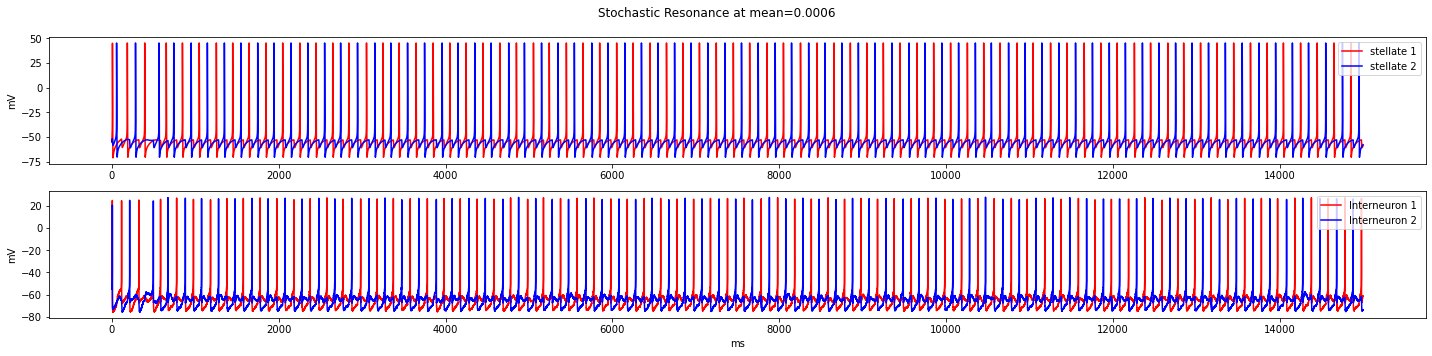

In [5]:
#plot stochastic resonance stdev=0.0015, mean=0.0006


ingauss1.stdev=0.0015
ingauss2.stdev= 0.0015
var=0.0006
ingauss1.mean = var
ingauss2.mean = var
h.finitialize(-55)
h.continuerun(sim_dur)
fig,axs = plt.subplots(2,1,figsize=(20,5))
p1=axs[0].plot(t,stell_v1,color='red',label='stellate 1')
p2=axs[0].plot(t,stell_v2,color='blue',label='stellate 2')
p3=axs[1].plot(t,int_v1,color='red',label='Interneuron 1')
p3=axs[1].plot(t,int_v2,color='blue',label='Interneuron 2')
axs[0].legend()
axs[1].legend(loc='upper right')
axs[1].set_xlabel('ms')
axs[1].set_ylabel('mV')
axs[0].set_ylabel('mV')
fig.suptitle('Stochastic Resonance at mean=0.0006')
fig.tight_layout()

<h3> Exploratory Analysis for Stocahstic Resonance: </h3>

In [ ]:
#functions
def stdevofbursts(spiketime1,spiketime2):
    '''calculate standard deviation of interburst interval
    input: spike time vector
    ouput: standard deviation of bursts'''
    spiketime1= np.array(spiketime1)
    spiketime1=spiketime1[spiketime1>1000] #ignore first second
    spiketime2= np.array(spiketime2)
    spiketime2=spiketime2[spiketime2>1000]
    burst1 = []
    burst2= []
    for i in range(1,len(spiketime1)):
        diff1 = spiketime1[i]-spiketime1[i-1]
        if diff1>50:
            
            burst1.append(spiketime1[i-1])
            burst1.append(spiketime1[i])
    for i in range(1,len(spiketime2)):
        diff2= spiketime2[i]-spiketime2[i-1]
        if diff2>50:
            burst2.append(spiketime2[i-1])
            burst2.append(spiketime2[i])
    burstintv1=np.ediff1d(burst1)
    burstintv2=np.ediff1d(burst2)
    stdevbursts1=np.std(burstintv1)/np.sqrt(len(burstintv1))
    stdevbursts2=np.std(burstintv1)/np.sqrt(len(burstintv2))
    return stdevbursts1,stdevbursts2

def amp_fft(data):
    '''fourier analysis [scipy]
    input: time series'
    output: amplitutdes and frequency'''
    L=len(data)
    si = 0.025e-3
    vec= signal.detrend(data)
    Y=fft.fft(vec)/L 
    power=np.real(np.multiply(Y,np.conj(Y)))
    F = fftpack.fftfreq(L,d=si)
    return abs(Y[0:int(L/2)]),F[0:int(L/2)]

def filter_func(int_vec):
    '''convolution [scipy]
    input: time series
    output: convolved input with boxcar window'''
    win=signal.windows.boxcar(25)
    filtered = signal.convolve(int_v1,win,mode='same')/sum(win)
    return filtered

def integration(y,x):
    '''simpsons integration between 9.8-10.2 Hz[scipy]
    input: function to integrate (y,x)
    output: area between the specified limit'''
    ll = 9.8
    ul= 10.2
    interval=np.where((x>=ll) & (x<=ul))[0]
    area = integrate.simps(y[interval],x[interval])
    return area


In [ ]:
#Standard Deviation of interburst interval 1
#compared against increasing values of standard deviation of Gaussian noise

n=100 #number of simulations
ing1l= [] #noise levels
stdev1=[] #standard deviation of interneuron, interburst intervals
stdev2=[]
ing1=0.001 #initial value
ingauss2.mean= 0
ingauss1.mean= 0
for i in range(n):
    ingauss1.stdev=ing1
    ingauss2.stdev=ing1
    h.finitialize(-55)
    h.continuerun(sim_dur)
    stdevbursts=stdevofbursts(spiketimes[0],spiketimes[1])
    stdev1.append(stdevbursts[0])
    stdev2.append(stdevbursts[1])
    ing1l.append(ing1)
    ing1 +=14e-5
    print(i,end=' ')

    
    
#plot
fig1,axs1 = plt.subplots(1,2,figsize=(18,5))
p1=axs1[0].scatter(ing1l,stdev1,color='red',label='Interneuron 1')
p2=axs1[1].scatter(ing1l,stdev2,color='blue',label='Interneuron 2')
for ax in axs1:
    ax.legend(loc='upper right')
    ax.set_xlabel('stdev of noise')
    ax.set_ylabel('stdev of interburst interval')
fig1.suptitle('Standard Deviation of interburst interval 1')
fig1.tight_layout()

In [ ]:
#Standard Deviation of interburst interval 2
#compared against increasing mean of Gaussian noise
n=1000
ing1l= []
stdev1=[]
stdev2=[]
ing1=-0.01
ingauss2.stdev= 0.0015
ingauss1.stdev= 0.0015
for i in range(n):
    ingauss1.mean=ing1
    ingauss2.mean=ing1
    h.finitialize(-55)
    h.continuerun(sim_dur)
    stdevbursts=stdevofbursts(spiketimes[0],spiketimes[1])
    stdev1.append(stdevbursts[0])
    stdev2.append(stdevbursts[1])
    ing1l.append(ing1)
    ing1 +=0.00002
    print(i,end=' ')
print(ing1)


#plot
fig2,axs2 = plt.subplots(1,2,figsize=(18,5))
p1=axs2[0].scatter(ing1l,stdev1,color='red',label='Interneuron 1')
p2=axs2[1].scatter(ing1l,stdev2,color='blue',label='Interneuron 2')
for ax in axs2:
    ax.legend(loc='upper right')
    ax.set_xlabel('Noise mean')
    ax.set_ylabel('stdev of interburst interval')
fig2.suptitle('Standard Deviation of interburst interval 2')
fig2.tight_layout()

In [ ]:
#Eg of spike train at stdev of noise:0.0015 and mean: 0.0005:

ingauss1.stdev=0.0015
ingauss2.stdev= 0.0015
var=0.0005
ingauss1.mean = var
ingauss2.mean = var
h.finitialize(-55)
h.continuerun(sim_dur)
fig,axs = plt.subplots(2,1,figsize=(20,5))
p1=axs[0].plot(t,stell_v1,color='red',label='stellate 1')
p2=axs[0].plot(t,stell_v2,color='blue',label='stellate 2')
p3=axs[1].plot(t,int_v1,color='red',label='Interneuron 1')
p3=axs[1].plot(t,int_v2,color='blue',label='Interneuron 2')
axs[0].legend()
axs[1].legend(loc='upper right')
axs[1].set_xlabel('ms')
axs[1].set_ylabel('mV')
axs[0].set_ylabel('mV')
fig.suptitle('Mean:0.0005, stdev:0.0015')
fig.tight_layout()

In [ ]:
#fourier analysis
n=1000
ing1l= []
amp=[]
freq=[]
ing1=0.0001
ingauss2.stdev= 0.0015
ingauss1.stdev= 0.0015
for i in range(n):
    ingauss1.mean=ing1
    ingauss2.mean=ing1
    h.finitialize(-55)
    h.continuerun(sim_dur)
    tempv1= list(int_v1)
    filtered = filter_func(tempv1[40000:len(tempv1)]) #ignore first second
    p0,f0=amp_fft(filtered)
    amp.append(p0)
    freq.append(f0)
    ing1l.append(ing1)
    ing1 +=9e-7
    print(i,end=' ')


#plot noise vs amp
area = []
for i,ft in enumerate(amp):
    area.append(integration(ft,freq[i]))
    
print(ing1l[np.argmax(area[0:len(amp)])]) #peak value
plt.figure()
plt.plot(ing1l,area,linewidth=1)
plt.xlabel('noise mean')
plt.ylabel('Area under 9.8-10.2 Hz')
plt.title('Fourier Analysis')

